In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'left',
    'right',
    'zoomin',
]

data = np.concatenate([
    np.load('dataset/seq_left_1653402855.npy'),
    np.load('dataset/seq_right_1653402855.npy'),
    np.load('dataset/seq_zoomin_1653402855.npy'),
], axis=0)

data.shape

(2130, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2130, 30, 99)
(2130,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2130, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1917, 30, 99) (1917, 3)
(213, 30, 99) (213, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('KSU_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
57/60 [===========================>..] - ETA: 0s - loss: 22.2291 - acc: 0.4178
Epoch 1: val_acc improved from -inf to 0.50704, saving model to KSU_model.h5
60/60 [==============================] - 1s 8ms/step - loss: 21.6372 - acc: 0.4199 - val_loss: 12.0597 - val_acc: 0.5070 - lr: 0.0010
Epoch 2/200
53/60 [=========================>....] - ETA: 0s - loss: 9.0125 - acc: 0.5200
Epoch 2: val_acc improved from 0.50704 to 0.55399, saving model to KSU_model.h5
60/60 [==============================] - 0s 6ms/step - loss: 9.2388 - acc: 0.5170 - val_loss: 8.2393 - val_acc: 0.5540 - lr: 0.0010
Epoch 3/200
52/60 [=========================>....] - ETA: 0s - loss: 12.0973 - acc: 0.4483
Epoch 3: val_acc did not improve from 0.55399
60/60 [==============================] - 0s 6ms/step - loss: 13.7705 - acc: 0.4471 - val_loss: 20.0842 - val_acc: 0.3615 - lr: 0.0010
Epoch 4/200
53/60 [=========================>....] - ETA: 0s - loss: 15.4831 - acc: 0.4540
Epoch 4: val_acc did not improve f

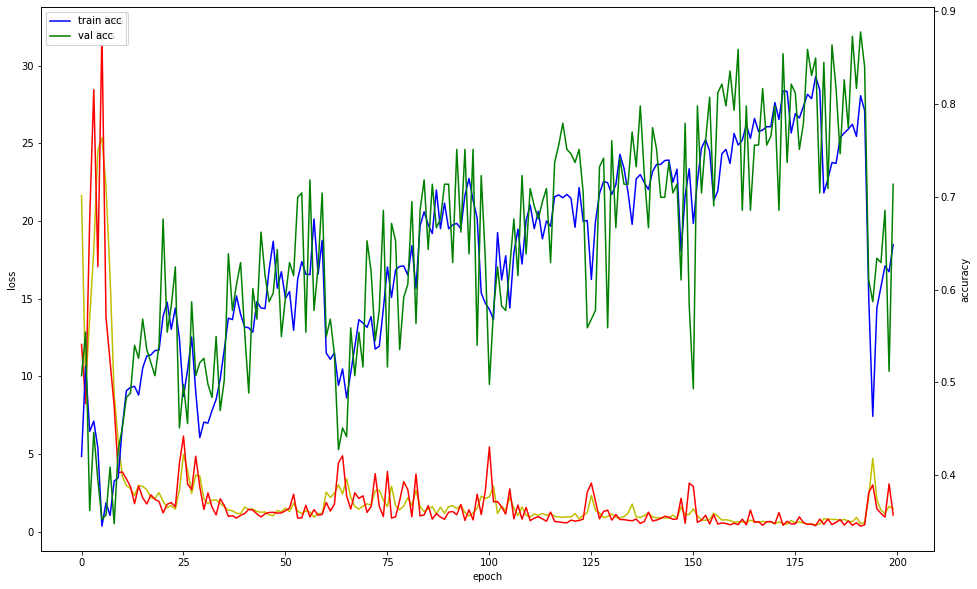

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('KSU_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

7/7 [==============================] - 0s 3ms/step


array([[[133,  10],
        [ 11,  59]],

       [[137,   7],
        [ 13,  56]],

       [[130,   9],
        [  2,  72]]], dtype=int64)